In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
import numpy as np
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from diffusers import UNet2DModel
from torch import amp
import os
import time
import copy

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
transforms = transforms.Compose([transforms.ToTensor(),transforms.Pad(2)])

In [5]:
train_ds = torchvision.datasets.FashionMNIST(root = './data/train',train = True,download = True,transform = transforms)
valid_ds = torchvision.datasets.FashionMNIST(root = './data/valid',train = False,download = True,transform = transforms)

In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size = 32, shuffle = True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_ds, batch_size = 32, shuffle = False)

In [7]:
# Define in-channels and out-channels as we have grayscale images and also change the out channels as we don't need a model as large as the default configuration

unet_model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 128),norm_num_groups=8, add_attention=(True, False, False, True))

In [8]:
class Unet(nn.Module):
    def __init__(self, model):
        super(Unet, self).__init__()
        self.model = model
    
    def forward(self, x):
        return self.model.forward(*x).sample

In [9]:
class DiffusionParams():
    def __init__(self):
        self.T = 1000
        self.beta = torch.linspace(start = 1e-4, end = 0.02, steps = self.T, dtype = torch.float32, device = device)
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim = 0)
        print(self.beta)
        print(self.alpha)

In [10]:
def forward_process(dp: DiffusionParams, x0: torch.Tensor, t: torch.Tensor):
    epsilon = torch.randn_like(x0)
    mean = torch.sqrt(dp.alpha_bar[t-1])
    mean = mean.view(-1, 1, 1, 1)
    std_dev = torch.sqrt(1 - dp.alpha_bar[t-1])
    std_dev = std_dev.view(-1, 1, 1, 1)
    return mean*x0 + std_dev*epsilon, epsilon


### FORWARD DIFFUSION 

tensor([1.0000e-04, 1.1992e-04, 1.3984e-04, 1.5976e-04, 1.7968e-04, 1.9960e-04,
        2.1952e-04, 2.3944e-04, 2.5936e-04, 2.7928e-04, 2.9920e-04, 3.1912e-04,
        3.3904e-04, 3.5896e-04, 3.7888e-04, 3.9880e-04, 4.1872e-04, 4.3864e-04,
        4.5856e-04, 4.7848e-04, 4.9840e-04, 5.1832e-04, 5.3824e-04, 5.5816e-04,
        5.7808e-04, 5.9800e-04, 6.1792e-04, 6.3784e-04, 6.5776e-04, 6.7768e-04,
        6.9760e-04, 7.1752e-04, 7.3744e-04, 7.5736e-04, 7.7728e-04, 7.9720e-04,
        8.1712e-04, 8.3704e-04, 8.5696e-04, 8.7688e-04, 8.9680e-04, 9.1672e-04,
        9.3664e-04, 9.5656e-04, 9.7648e-04, 9.9640e-04, 1.0163e-03, 1.0362e-03,
        1.0562e-03, 1.0761e-03, 1.0960e-03, 1.1159e-03, 1.1358e-03, 1.1558e-03,
        1.1757e-03, 1.1956e-03, 1.2155e-03, 1.2354e-03, 1.2554e-03, 1.2753e-03,
        1.2952e-03, 1.3151e-03, 1.3350e-03, 1.3550e-03, 1.3749e-03, 1.3948e-03,
        1.4147e-03, 1.4346e-03, 1.4546e-03, 1.4745e-03, 1.4944e-03, 1.5143e-03,
        1.5342e-03, 1.5542e-03, 1.5741e-

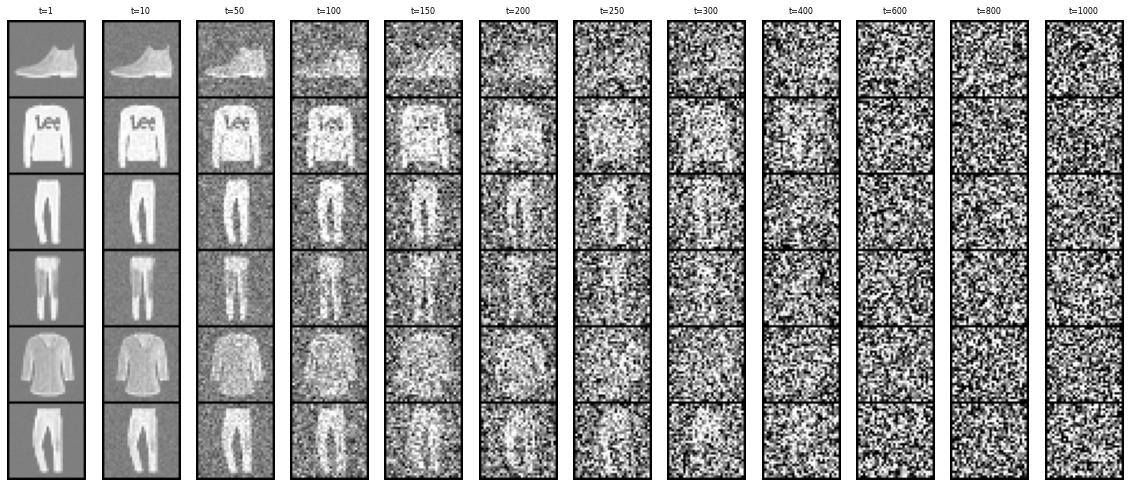

In [11]:
dp = DiffusionParams()
batch = next(iter(valid_loader))
images,labels = batch
batch = images.to(device), labels.to(device)
x0s = images[:6]
x0s = x0s.to(device)
noisy_images = []
specific_timesteps = [1, 10, 50, 100, 150, 200, 250, 300, 400, 600, 800, 1000]
for timestep in specific_timesteps:
    timestep = torch.as_tensor(timestep, dtype=torch.long)
 
    xts, _ = forward_process(dp, x0s, timestep)
    xts    = (xts.clamp(-1, 1)+1.0)/2.0
    xts    = make_grid(xts, nrow=1, padding=1)
     
    noisy_images.append(xts)

_, ax = plt.subplots(1, len(noisy_images), figsize=(20, 10), facecolor='white')
 
for i, (timestep, noisy_sample) in enumerate(zip(specific_timesteps, noisy_images)):
    noisy_sample=noisy_sample.to('cpu')
    ax[i].imshow(noisy_sample.squeeze(0).permute(1, 2, 0))
    ax[i].set_title(f"t={timestep}", fontsize=8)
    ax[i].axis("off")
    ax[i].grid(False)
 
plt.axis("off")
plt.show()


### TRAINING FUNCTION

In [17]:
def train(model, criterion, optimizer, train, loader):
    if train == True:
        model.train()
    else:
        model.eval()
    mean_loss = 0
    for images, _ in loader:
        images = images.to(device)
        t = torch.randint(low = 1, high= dp.T, size = (images.shape[0],), device = device)
        xt, eps = forward_process(dp, images, t.clone())
        loss = criterion(eps, model((xt, t.clone()-1)))
        if train == True: 
            optimizer.step()
            optimizer.zero_grad()
            loss.backward()
        mean_loss += (loss.item()/32)
    
    return mean_loss


### SAMPLING FUNCTION

In [13]:
@torch.no_grad()
def sample(model):
    xT = torch.randn((6, 1, 32, 32), device = device)
    x_t_1 = xT
    model.eval()
    for i in range(1000, 0, -1):
        z = torch.randn_like(xT, device=device) if i != 1 else torch.zeros_like(xT, device = device)
        ts = torch.ones(6, dtype=torch.long, device=device) * (i-1)
        noise_pred = model((x_t_1, ts))
        t1 = 1/(torch.sqrt(dp.alpha_bar[ts])).view(-1, 1, 1, 1)
        t2 = (1-dp.alpha[ts]).view(-1, 1, 1, 1)
        t3 = (torch.sqrt(1-dp.alpha_bar[ts])).view(-1, 1, 1, 1)
        t4 = (dp.beta[ts]).view(-1, 1, 1, 1)
        x_t_1 = (t1)*((x_t_1) - ((t2)/(t3))*(noise_pred)) + t4*z
    
    return x_t_1


### TRAINING

In [14]:
model = Unet(unet_model).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 2e-4)
criterion = nn.MSELoss()

In [18]:
num_epochs = 20
torch.set_detect_anomaly(True)
generated_images = []
for epoch in range(num_epochs):
    if epoch%20 == 0:
        generated_images.append(sample(model))
    mean_train_loss = train(model = model, criterion = criterion, optimizer = optimizer, train = True, loader = train_loader)
    mean_valid_loss = train(model = model, criterion = criterion, optimizer = optimizer, train = False, loader = valid_loader)
    print(f"Epoch: {epoch+1}/{20}: Train Loss : {mean_train_loss}")
    print(f"Epoch: {epoch+1}/{20}: Valid Loss : {mean_valid_loss}")
torch.save(model,'diffusion.pth')

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [1, 32, 3, 3]] is at version 4; expected version 3 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [ ]:
_, ax = plt.subplots(1, len(generated_images), figsize=(20, 10), facecolor='white')
 
for i, generated_image in enumerate(zip(generated_images)):
    generated_image = generated_image.to(device)
    ax[i].imshow(generated_image.squeeze(0).permute(1, 2, 0))
    ax[i].set_title(f"t={i*20}", fontsize=8)
    ax[i].axis("off")
    ax[i].grid(False)
 
plt.axis("off")
plt.show()
